# This notebook is a continuation of the multicategory project to check working memory. 
## we are creating the rsvp paradigm with 4 images (target + 3 background), because the batches from experiment 1 resulted only in 30% subjects achiving above chance. 
## We are using the same raw data (located in the multicategory project folder) and the same taregt and distractor images (located aswell in that directory)


### We begin by choosing randomly new backround images (50 from each category).
### Then, we select a set of 4 different images for each target from different categories 
### finaly, we create 100 experimental csv files. 

In [1]:
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import random
import os
import shutil
from itertools import chain
import seaborn as sns 

In [2]:
project_name_images = 'multicategory'
project_name_outputs = 'multicategory_working_memory'
PATH_TO_PROJECT = Path.cwd().parent.parent.parent / 'projects' / project_name_outputs
PATH_TO_IMAGES = Path.cwd().parent.parent.parent / 'projects' / project_name_images / 'raw data' 
PATH_TO_SAVE_CSV_FILES = PATH_TO_PROJECT/ 'experiment 3' / 'experiment resources' / 'csvs'
PATH_TO_SELECTED_IMAGES = PATH_TO_PROJECT/ 'experiment 3' / 'experiment resources' / 'images' / 'all experiment images'

### Load the selected targets and distractors names 

In [3]:
targets_and_distractors = pd.read_csv(PATH_TO_PROJECT/'targets_and_distractors.csv')

### Select 40 random background images from each category

In [4]:
selected_images_names = list(targets_and_distractors.values.flatten())

In [5]:
def copy_images_to_folder(image_list, source_path,destination_folder):
    # Iterate over the image list and copy each image to the destination folder
    for image_name in image_list:
        cur_source_path = os.path.join(source_path, image_name)
        destination_path = os.path.join(destination_folder,image_name)
        shutil.copyfile(cur_source_path, destination_path)

In [19]:
select_random_background_images = True # if this is set to true, new images will be selected! 
                                        # this is done randomly so there will be more than 540 images in the folder.

cat_names = ['badlands','bridge','playground','mountain','highway','golf_course']
if select_random_background_images:
    for x in PATH_TO_IMAGES.iterdir():
        curr_cat = x.name
        if curr_cat in cat_names:
            all_cat_images = os.listdir(x)
            all_avaliable_images = set(all_cat_images) - set(selected_images_names)
            selected_backround_images = random.sample(all_avaliable_images,40)
            source_path = PATH_TO_IMAGES / curr_cat
            copy_images_to_folder(selected_backround_images,source_path,PATH_TO_SELECTED_IMAGES)
        

/var/folders/35/zj9lmn1x0ygd3qmyy6yx328w0000gn/T/ipykernel_70137/3731460210.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_backround_images = random.sample(all_avaliable_images,40)


### Now we will create the subejct csvs 

In [20]:
all_images = [imname for imname in os.listdir(PATH_TO_SELECTED_IMAGES) if '.jpg' in imname]
optional_background_images = set(all_images) - set(selected_images_names)

In [21]:
len(optional_background_images)

240

In [47]:
for sub in range(100):
    curr_experiment_df = targets_and_distractors.copy()
    previosly_selected_backround_images = []
    # Function to select random value from dist_0 or dist_1 and assign distractor_level
    def select_random_distractor(row):
        target_image = row['target']
     
        selected_dist = row['selected_dist']
        image1 = random.choice([target_image,selected_dist])
        if image1 == target_image:
            image2 = selected_dist
            correct = 'left'
        else: 
            image2 = target_image
            correct = 'right'
        return pd.Series([image1,image2,correct])

    # select random distractor for each target
    curr_experiment_df = curr_experiment_df.sample(frac=1)
    curr_experiment_df.reset_index(inplace=True,drop=True)
    #select the 30 first rows for dist 0: 
    level_0_dist = list(curr_experiment_df['dist_0'][0:30].values)
    level_1_dist = list(curr_experiment_df['dist_1'][30:].values)
    all_distractors = level_0_dist + level_1_dist
    curr_experiment_df['selected_dist'] = all_distractors 
    curr_experiment_df['distractor_level'] = [0] * 30 + [1] * 30

    curr_experiment_df[['image1','image2','correct']] = curr_experiment_df.apply(select_random_distractor, axis=1)
    curr_experiment_df.drop(['dist_0','dist_1'],axis = 1,inplace=True)

    # add category name column 
    curr_experiment_df['category'] = curr_experiment_df['target'].apply(lambda x: x.split('_')[0])

    # select 4 random image from different category than the target 
    def select_random_backround_images(row):
        category_name = row['category']
        target_image = row['target']
        # removing background images from the same category as target 
        cur_optional_background_images = [x for x in optional_background_images if category_name not in x]
        # removing background images that have been selected
        cur_optional_background_images = [x for x in cur_optional_background_images if x not in list(chain.from_iterable(previosly_selected_backround_images))]
        random.shuffle(cur_optional_background_images)
        selected_images = {}
        # Iterate over the image names
        for name in cur_optional_background_images:
            # Extract the category from the image name
            category = name.split("_")[0]
            # Check if the category is already in the selected images dictionary
            if category not in selected_images and len(list(selected_images.keys())) < 3:
                # If not, get all the images belonging to that category
                category_images = [image for image in cur_optional_background_images if image.startswith(category)]
                # Randomly select one image from the category
                selected_image = random.choice(category_images)
                # Add the selected image to the dictionary
                selected_images[category] = selected_image


        selected_images = random.sample(list(selected_images.values()),len(list(selected_images.values())))
        previosly_selected_backround_images.append(selected_images)
        # inserting target image name between 0-3 (not last index)
        random_index_target = random.randint(0, 2)
        selected_images.insert(random_index_target,target_image)
        selected_images.append(random_index_target)
        return selected_images

    selected_background = curr_experiment_df.apply(select_random_backround_images, axis=1)
    # Add each value in the series to separate columns
    selected_background = selected_background.apply(pd.Series)

    # Rename the columns
    selected_background.columns = [f'background_{i}' for i in range(selected_background.shape[1])]
    selected_background = selected_background.rename({'background_4':'target_index'},axis=1)
    # Concatenate the existing DataFrame and the new columns
    curr_experiment_df = pd.concat([curr_experiment_df, selected_background], axis=1)
    print(f'there are {curr_experiment_df.isna().sum().sum()} nan values')
    n = len(set(list(curr_experiment_df[['background_0','background_1','background_2','background_3']].values.flatten())))
    print(f'n = {n}')
    # now we randomize the row order
    curr_experiment_df['background_4'] = curr_experiment_df['background_3'] 
    curr_experiment_df['background_5'] = curr_experiment_df['background_4'] 
    curr_experiment_df = curr_experiment_df.sample(frac=1)
    curr_experiment_df.reset_index(inplace=True,drop=True)
    curr_experiment_df.to_csv(PATH_TO_SAVE_CSV_FILES/f'sub_{sub}.csv',index=False)

there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there are 0 nan values
n = 240
there ar

In [48]:
target_locations=[]
for i in range(len(curr_experiment_df)):
    cur_target=curr_experiment_df['target'].iloc[i]
    backgrounds = curr_experiment_df[['background_0','background_1','background_2','background_3']].iloc[i].values
    cur_target_exists = np.argwhere(cur_target==backgrounds)[0][0]
    target_locations.append(cur_target_exists)

(array([21.,  0.,  0.,  0.,  0., 18.,  0.,  0.,  0., 21.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

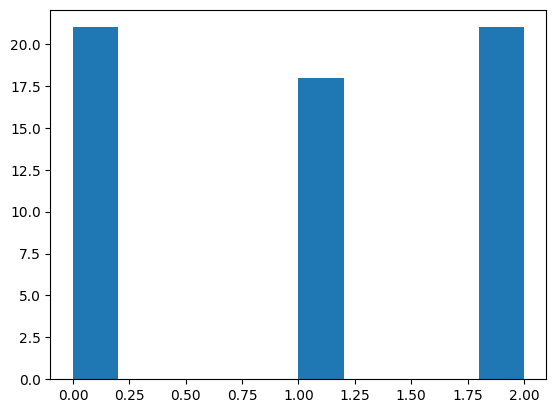

In [49]:
plt.figure()
plt.hist(target_locations)